In [17]:
!pip install boto3

In [18]:
import os
import numpy as np
import cv2
import dlib
import boto3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [19]:
# google colab용 코드
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
def visualize_feature(features, labels, feature_idx, feature_name):
    feature_values = [item[feature_idx] for item in features]
    unique_labels = list(set(labels))
    grouped_values = {label: [] for label in unique_labels}

    for value, label in zip(feature_values, labels):
        grouped_values[label].append(value)

    x_labels = []
    y_values = []

    for label in unique_labels:
        x_labels.append(label)
        y_values.append(grouped_values[label])

    fig, ax = plt.subplots()
    box = ax.boxplot(y_values, labels=x_labels, patch_artist=True)

    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xlabel('Label')
    ax.set_ylabel(f'{feature_name} Value')
    ax.set_title(f'{feature_name}')

    medians = [np.median(grouped_values[label]) for label in unique_labels]
    median_min = min(medians)
    median_max = max(medians)
    margin = (median_max - median_min) * 0.5
    ax.set_ylim(median_min - margin, median_max + margin)

    ax.set_yticks(np.arange(min(feature_values), max(feature_values) + 1, step=(max(feature_values) - min(feature_values)) / 10))

    for i, line in enumerate(box['medians']):
        x, y = line.get_xydata()[1]
        ax.text(x, y, f'{y:.4f}', horizontalalignment='center', fontsize=8, color='black')

    plt.show()

def visualize_all_features(features, labels):
    feature_names = [
        "Mouth Width",
        "Top Face Slope",
        "Bottom Face Slope",
        "Eye Width",
        "Eyebrow Distance",
        "Nose Ratio",
        "Mustache",
        "Beard"
    ]

    for idx, feature_name in enumerate(feature_names):
        try:
            visualize_feature(features, labels, idx, feature_name)
        except IndexError as e:
            print(f"Error: {e}. Index: {idx}, Feature Name: {feature_name}")

In [22]:
image_base_dir = '/content/drive/MyDrive/ML_Project_/'
label_dirs = ["east_asian_actor/", "bollywood_actor/", "caucasian_actor/", "south_america/"]
label_map = {0: "East Asian", 1: "Bollywood", 2: "Caucasian", 3: "South America"}

In [23]:
MOUTH_LEFT_IDX = 48
MOUTH_RIGHT_IDX = 54

LEFT_EYE_LEFT_IDX = 36
LEFT_EYE_RIGHT_IDX = 39

RIGHT_EYE_LEFT_IDX = 42
RIGHT_EYE_RIGHT_IDX = 45

LEFT_EYEBROW = 19
LEFT_EYE_IDX1 = 37
LEFT_EYE_IDX2 = 38

RIGHT_EYEBROW = 24
RIGHT_EYE_IDX1 = 43
RIGHT_EYE_IDX2 = 44

In [24]:
# mustache와 beard 유무를 구하는 함수
def detect_mustache_and_beard(image_path):
    # aws 관련 키 넣기
    aws_access_key_id = ''
    aws_secret_access_key = ''
    region_name = ''

    client = boto3.client('rekognition', region_name=region_name, aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

    # 이미지 크기를 확인하여 5MB를 초과하는 경우 건너뛰기
    image_size = os.path.getsize(image_path)
    if image_size > 5 * 1024 * 1024:  # 5MB
        print(f"Skipping image '{image_path}' due to exceeding 5MB size limit.")
        os.remove(image_path)
        return 0, 0

    with open(image_path, 'rb') as image_file:
        image_data = image_file.read()
        response = client.detect_faces(
            Image={'Bytes': image_data},
            Attributes=['ALL']
        )

    mustache = 0
    beard = 0

    if 'FaceDetails' in response:
        for faceDetail in response['FaceDetails']:
            if 'Mustache' in faceDetail and faceDetail['Mustache']['Value']:
                mustache = 1
            if 'Beard' in faceDetail and faceDetail['Beard']['Value']:
                beard = 1

    return mustache, beard

In [25]:
# 입의 크기를 구하는 함수
def get_mouth_width(face_left, face_right, landmarks):
    return (landmarks.part(MOUTH_RIGHT_IDX).x - landmarks.part(MOUTH_LEFT_IDX).x) / (face_right - face_left)

# 얼굴의 각도를 구하는 함수
def get_face_slope_pair(landmarks):
    try:
        left_top_slope = abs(landmarks.part(0).y - landmarks.part(4).y) / abs(landmarks.part(0).x - landmarks.part(4).x)
        right_top_slope = abs(landmarks.part(16).y - landmarks.part(12).y) / abs(landmarks.part(16).x - landmarks.part(12).x)

        left_bottom_slope = abs(landmarks.part(5).y - landmarks.part(8).y) / abs(landmarks.part(5).x - landmarks.part(8).x)
        right_bottom_slope = abs(landmarks.part(11).y - landmarks.part(8).y) / abs(landmarks.part(11).x - landmarks.part(8).x)

        top_slope_avg = (left_top_slope + right_top_slope) / 2
        bottom_slope_avg = (left_bottom_slope + right_bottom_slope) / 2
        return top_slope_avg, bottom_slope_avg
    except ZeroDivisionError:
        return 0, 0

In [26]:
# 눈 크기 측정
def get_left_eye_width(face_left, face_right, landmarks):
    return (landmarks.part(LEFT_EYE_RIGHT_IDX).x - landmarks.part(LEFT_EYE_LEFT_IDX).x) / (face_right - face_left)

def get_right_eye_width(face_left, face_right, landmarks):
    return (landmarks.part(RIGHT_EYE_RIGHT_IDX).x - landmarks.part(RIGHT_EYE_LEFT_IDX).x) / (face_right - face_left)

def get_eye_width(face_left, face_right, landmarks):
    left_eye_width = get_left_eye_width(face_left, face_right, landmarks)
    right_eye_width = get_right_eye_width(face_left, face_right, landmarks)
    average_width = (left_eye_width + right_eye_width) / 2
    return average_width

# 눈과 눈썹 사이 거리 측정 함수
def get_left_eyebrow_distance(face_top, face_bottom, landmarks):
    distance1 = (landmarks.part(LEFT_EYEBROW).y - landmarks.part(LEFT_EYE_IDX1).y) / (face_top - face_bottom)
    distance2 = (landmarks.part(LEFT_EYEBROW).y - landmarks.part(LEFT_EYE_IDX2).y) / (face_top - face_bottom)
    return min(distance1, distance2)

def get_right_eyebrow_distance(face_top, face_bottom, landmarks):
    distance1 = (landmarks.part(RIGHT_EYEBROW).y - landmarks.part(RIGHT_EYE_IDX1).y) / (face_top - face_bottom)
    distance2 = (landmarks.part(RIGHT_EYEBROW).y - landmarks.part(RIGHT_EYE_IDX2).y) / (face_top - face_bottom)
    return min(distance1, distance2)

def get_eyebrow_distance(face_top, face_bottom, landmarks):
    left_eyebrow = get_left_eyebrow_distance(face_top, face_bottom, landmarks)
    right_eyebrow = get_right_eyebrow_distance(face_top, face_bottom, landmarks)
    average_eyebrow_width = (left_eyebrow + right_eyebrow) / 2
    return average_eyebrow_width

In [27]:
# 코 관련 함수
def bezier_curve(p0, p1, p2, n_points=4):
    points = []
    for t in [i / (n_points - 1) for i in range(n_points)]:
        x = (1 - t)**2 * p0[0] + 2 * (1 - t) * t * p1[0] + t**2 * p2[0]
        y = (1 - t)**2 * p0[1] + 2 * (1 - t) * t * p1[1] + t**2 * p2[1]
        points.append((x, y))
    return points

def shoelace_formula(vertices):
    n = len(vertices)
    area = 0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += x1 * y2
        area -= y1 * x2

    area = abs(area) / 2.0
    return area

def get_nose_ratio(landmarks):
    nose_line1 = landmarks.part(27)
    nose_line2 = landmarks.part(28)
    nose_line3 = landmarks.part(29)
    nose_line4 = landmarks.part(30)

    nose_bottom1 = landmarks.part(31)
    nose_bottom2 = landmarks.part(32)
    nose_bottom3 = landmarks.part(33)
    nose_bottom4 = landmarks.part(34)
    nose_bottom5 = landmarks.part(35)

    p1 = (nose_bottom2.x, nose_line2.y)
    p2 = (nose_bottom4.x, nose_line2.y)

    p3 = (nose_bottom2.x, nose_line3.y)
    p4 = (nose_bottom4.x, nose_line3.y)

    p5 = (nose_bottom1.x, nose_line4.y)
    p6 = (nose_bottom5.x, nose_line4.y)

    nose_points = [
        (nose_line1.x, nose_line1.y),
        (nose_bottom1.x, nose_bottom1.y),
        (nose_bottom3.x, nose_bottom3.y),
        (nose_bottom5.x, nose_bottom5.y),
    ]

    nose_points.extend([p1, p2, p3, p4, p5, p6])

    nose_points.extend(bezier_curve(
        (nose_bottom1.x, nose_bottom1.y),
        (nose_line4.x, nose_line4.y),
        (nose_bottom3.x, nose_bottom3.y)
    ))

    nose_points.extend(bezier_curve(
        (nose_bottom5.x, nose_bottom5.y),
        (nose_line4.x, nose_line4.y),
        (nose_bottom3.x, nose_bottom3.y)
    ))

    return shoelace_formula(nose_points)

In [31]:
def process_images(image_base_dir, label_dirs, detector, predictor):
    features = []
    labels = []

    for label_index, label_dir in enumerate(label_dirs):
        label_path = os.path.join(image_base_dir, label_dir)

        for filename in os.listdir(label_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(label_path, filename)

                try:
                    mustache, beard = detect_mustache_and_beard(image_path)
                except Exception as e:
                    print(f"Error occurred while detecting mustache and beard: {e}")
                    continue

                try:
                    image = cv2.imread(image_path)
                    if image is None:
                      raise ValueError(f"Error: 이미지를 불러올 수 없습니다. 파일 형식을 확인하세요: {image_path}")
                except ValueError as e:
                  print(e)
                  continue
                except Exception as e:
                  print(f"Unhandled exception occurred: {e}")
                  continue

                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = detector(gray)

                if not faces:
                    # 얼굴이 감지되지 않은 경우 건너뜁니다.
                    continue

                face = faces[0]  # 하나의 얼굴만 처리합니다.
                landmarks = predictor(gray, face)
                face_left = face.left()
                face_right = face.right()
                face_top = face.top()
                face_bottom = face.bottom()

                feature_vector = [
                    get_mouth_width(face_left, face_right, landmarks),
                    *get_face_slope_pair(landmarks),
                    get_eye_width(face_left, face_right, landmarks),
                    get_eyebrow_distance(face_top, face_bottom, landmarks),
                    get_nose_ratio(landmarks),
                    mustache,
                    beard
                ]

                features.append(feature_vector)
                labels.append(label_index)  # 인종 레이블 추가

    return features, labels

Skipping image '/content/drive/MyDrive/ML_Project_/east_asian_actor/rmyNzGNwbAL8636275908326524258.jpg' due to exceeding 5MB size limit.
Unhandled exception occurred: name 'file_path' is not defined
Skipping image '/content/drive/MyDrive/ML_Project_/east_asian_actor/09a99c7c-e66b-457b-a188-9e5cc7d0fefd.jpg' due to exceeding 5MB size limit.
Unhandled exception occurred: name 'file_path' is not defined
Skipping image '/content/drive/MyDrive/ML_Project_/east_asian_actor/3d224110-33ef-4e3e-8b53-cfe67345f8c3.jpg' due to exceeding 5MB size limit.
Unhandled exception occurred: name 'file_path' is not defined
Skipping image '/content/drive/MyDrive/ML_Project_/east_asian_actor/201903210941357673_d.jpg' due to exceeding 5MB size limit.
Unhandled exception occurred: name 'file_path' is not defined
Error occurred while detecting mustache and beard: An error occurred (InvalidImageFormatException) when calling the DetectFaces operation: Request has invalid image format
Error occurred while detecting

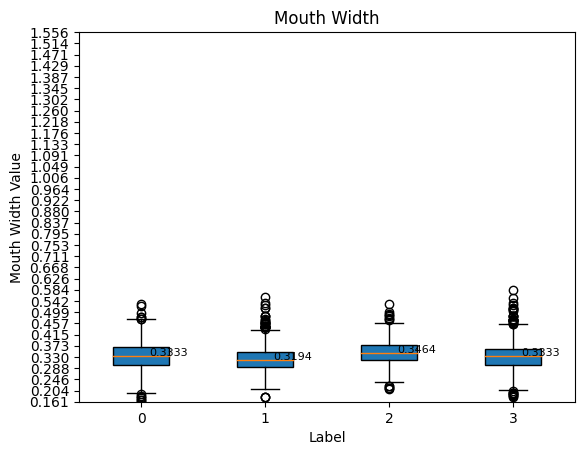

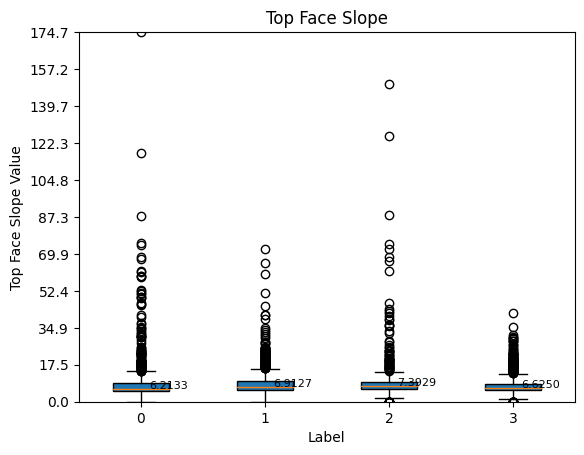

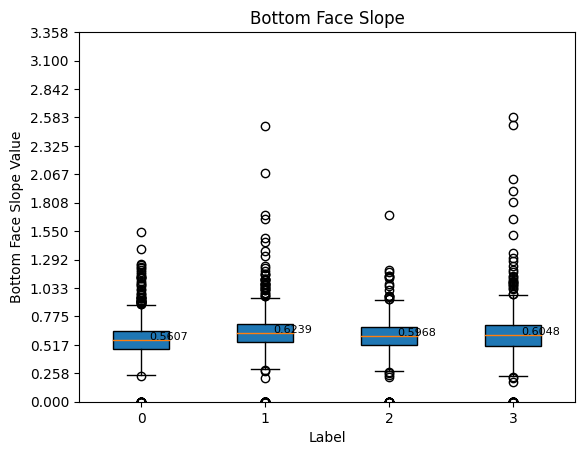

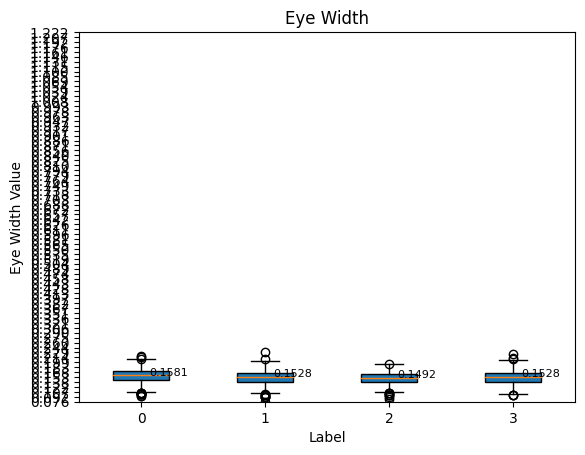

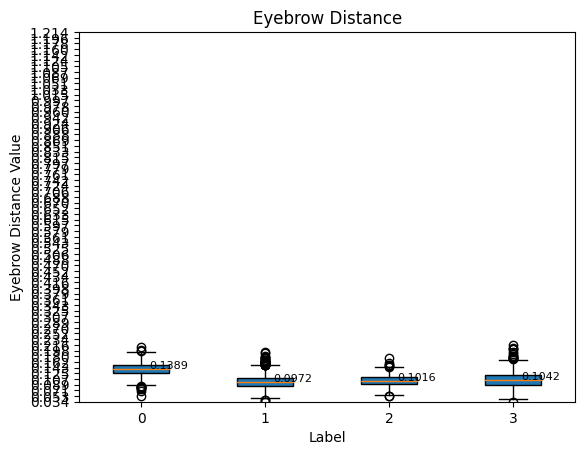

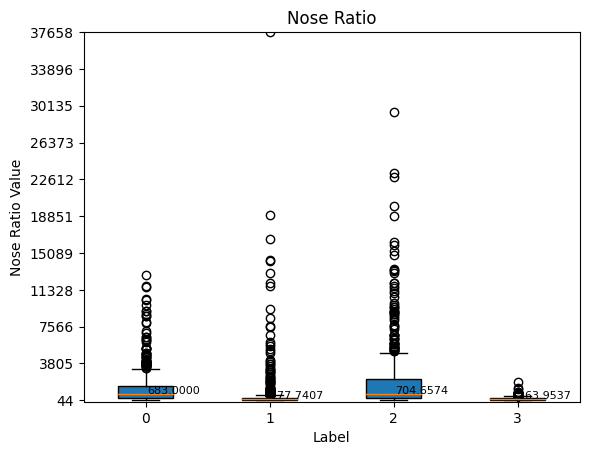

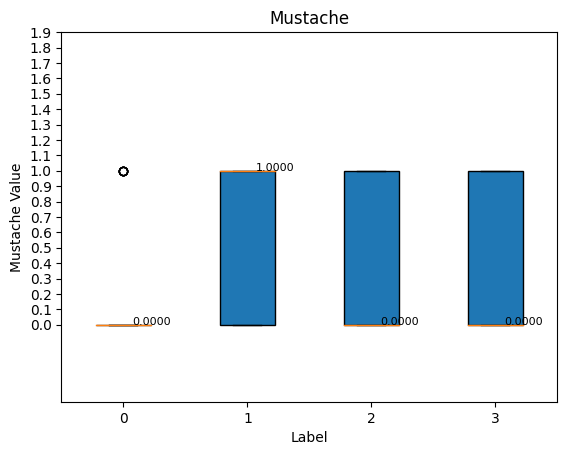

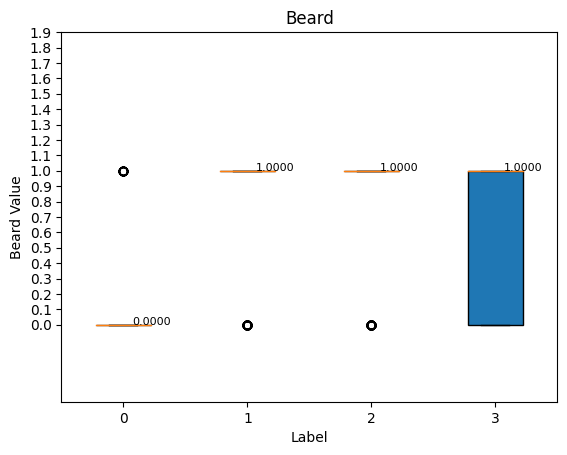

k: 1, accuracy: 56.52
k: 2, accuracy: 56.68
k: 3, accuracy: 56.99
k: 4, accuracy: 60.25
k: 5, accuracy: 59.47
k: 6, accuracy: 60.71
k: 7, accuracy: 62.58
k: 8, accuracy: 63.20
k: 9, accuracy: 63.35
k: 10, accuracy: 65.06
               precision    recall  f1-score   support

   East Asian       0.81      0.91      0.86       196
    Bollywood       0.57      0.62      0.60       167
    Caucasian       0.56      0.51      0.54        88
South America       0.56      0.47      0.51       193

     accuracy                           0.65       644
    macro avg       0.63      0.63      0.63       644
 weighted avg       0.64      0.65      0.64       644



In [32]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/ML_Project_/shape_predictor_68_face_landmarks.dat")
features, labels = process_images(image_base_dir, label_dirs, detector, predictor)

# Visualization
visualize_all_features(features, labels)

# Data preprocessing and model training/evaluation
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# test set과 train set을 분리
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# 최적의 k값 찾기
best_k = 1
best_score = 0
for k in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    if score > best_score:
        best_k = k
        best_score = score
    print('k: %d, accuracy: %.2f' % (k, score*100))

print("최적의 k값: ", best_k)

# 최적의 k값으로 모델 학습
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(X_train, y_train)

# 모델 평가
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[label_map[i] for i in label_map]))


In [38]:
def predict_new_image(image_path, knn, scaler, detector, predictor):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Error: 이미지를 불러올 수 없습니다. 파일 형식을 확인하세요: {image_path}")
    except ValueError as e:
        print(e)
        return None
    except Exception as e:
        print(f"Unhandled exception occurred: {e}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if not faces:
        print("Error: 얼굴을 감지하지 못했습니다.")
        return None

    face = faces[0]
    landmarks = predictor(gray, face)
    face_left = face.left()
    face_right = face.right()
    face_top = face.top()
    face_bottom = face.bottom()

    mustache, beard = detect_mustache_and_beard(image_path)

    feature_vector = [
        get_mouth_width(face_left, face_right, landmarks),
        *get_face_slope_pair(landmarks),
        get_eye_width(face_left, face_right, landmarks),
        get_eyebrow_distance(face_top, face_bottom, landmarks),
        get_nose_ratio(landmarks),
        mustache,
        beard
    ]

    features = np.array(feature_vector).reshape(1, -1)
    features_scaled = scaler.transform(features)

    label = knn.predict(features_scaled)
    return label[0]

In [39]:
# 새로운 이미지 예측
image_path = '/content/drive/MyDrive/ML_Project_/김태형 교수님.jpeg' 
# 예측하고자 하는 새로운 이미지 경로
predicted_label = predict_new_image(image_path, knn, scaler, detector, predictor)
if predicted_label is not None:
    print("Predicted label:", label_map[predicted_label])

k: 1, accuracy: 56.52
k: 2, accuracy: 56.68
k: 3, accuracy: 56.99
k: 4, accuracy: 60.25
k: 5, accuracy: 59.47
k: 6, accuracy: 60.71
k: 7, accuracy: 62.58
k: 8, accuracy: 63.20
k: 9, accuracy: 63.35
k: 10, accuracy: 65.06
k: 11, accuracy: 63.51
k: 12, accuracy: 64.13
k: 13, accuracy: 63.82
k: 14, accuracy: 64.60
k: 15, accuracy: 63.35
k: 16, accuracy: 63.20
k: 17, accuracy: 64.60
k: 18, accuracy: 64.13
k: 19, accuracy: 63.35
k: 20, accuracy: 63.51
k: 21, accuracy: 64.13
k: 22, accuracy: 63.35
k: 23, accuracy: 64.75
k: 24, accuracy: 64.44
k: 25, accuracy: 64.13
k: 26, accuracy: 64.44
k: 27, accuracy: 64.13
k: 28, accuracy: 65.22
k: 29, accuracy: 65.22
k: 30, accuracy: 63.98
k: 31, accuracy: 63.66
k: 32, accuracy: 63.82
k: 33, accuracy: 63.82
k: 34, accuracy: 63.82
k: 35, accuracy: 63.98
k: 36, accuracy: 63.82
k: 37, accuracy: 62.73
k: 38, accuracy: 63.51
k: 39, accuracy: 63.66
k: 40, accuracy: 64.13
k: 41, accuracy: 63.20
k: 42, accuracy: 63.51
k: 43, accuracy: 63.04
k: 44, accuracy: 63.